<a href="https://colab.research.google.com/github/otanet/WebScraping_2023_sub/blob/main/Wordcloud_FreqTable_tryal_20230107.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 手元のテキストデータでワードクラウド描こう（パート2）～TF-IDF編～ - Qiita
### https://qiita.com/hima2b4/items/bc9c0fac30b6437c5737

In [1]:
#Mecabのインストール
!pip install mecab-python3==0.996.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 45.2 MB/s eta 0:00:00


In [2]:
#日本語フォントをインストール
!apt-get -y install fonts-ipafont-gothic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-ipafont-mincho
The following NEW packages will be installed:
  fonts-ipafont-gothic fonts-ipafont-mincho
0 upgraded, 2 newly installed, 0 to remove and 21 not upgraded.
Need to get 8,251 kB of archives.
After this operation, 28.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-ipafont-gothic all 00303-18ubuntu1 [3,526 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-ipafont-mincho all 00303-18ubuntu1 [4,725 kB]
Fetched 8,251 kB in 1s (5,742 kB/s)
Selecting previously unselected package fonts-ipafont-gothic.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../fonts-ipafont-g

In [4]:
#nlplotをインストール
!pip install nlplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 967.9/967.9 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.2 MB/s eta 0:00:00


In [5]:
import MeCab as mc
import re           # 正規表現
import numpy as np

In [6]:
def strip_CRLF_from_Text(text):
    """
    テキストファイルの改行，タブを削除する．
    改行文字やタブ文字の前後が日本語文字の場合はそれを削除する．
    それ以外はスペースに置換する．
    """
    # 改行前後の文字が日本語文字の場合は改行を削除する
    plaintext = re.sub('([ぁ-んー]+|[ァ-ンー]+|[\\u4e00-\\u9FFF]+|[ぁ-んァ-ンー\\u4e00-\\u9FFF]+)(\n)([ぁ-んー]+|[ァ-ンー]+|[\\u4e00-\\u9FFF]+|[ぁ-んァ-ンー\\u4e00-\\u9FFF]+)',
                       r'\1\3',
                       text)
    # 残った改行とタブ記号はスペースに置換する
    plaintext = plaintext.replace('\n', ' ').replace('\t', ' ')
    return plaintext


def get_Text_from_Filenames(filenames):
    """
    ファイル名のリストを与えて，辞書を作成して返す
    """
    raw = ''
    # ファイルを開く
    for filename in filenames:
        f = open(filename,encoding='utf-8')
        raw += f.read()
        f.close()

    # 改行を削除する
    text = strip_CRLF_from_Text(raw)
    return text

def mecab_analysis(text):
    """
    MeCabをつかって単語を切り出してリストに詰める関数．
    可視化して意味がありそうな単語を抽出するために品詞は名詞だけ（あるいは名詞、動詞、形容詞、副詞）に限定．
    """
#    t = mc.Tagger('-Owakati')
    t = mc.Tagger('-Ochasen')

    node = t.parseToNode(text)

    words = []

    while(node):

        if node.surface != "":  # ヘッダとフッタを除外
            word_type = node.feature.split(",")[0]
            sub_type = node.feature.split(',')[1]
            features_ = node.feature.split(",")

            #ストップワード設定（出力結果から手動で設定）
            stop_words = ["し","い","ある", "おる", "せる", "ない", "いる", "する", "の", "よう", "なる", "それ", "そこ", "これ", "こう", "ため", "そう", "れる", "られる"]

            if word_type in ["名詞"]:  # 名詞をリストに追加する
                if sub_type in ['一般']:
                    words.append(node.surface)

            #動詞、形容詞[基礎型]を抽出（名詞のみを抽出したい場合は以下コードを除く）
            elif word_type in ['動詞','形容詞'] and not (features_[6] in stop_words):
                    words.append(features_[6])

        node = node.next
        if node is None:
            break
    return words

def get_DF_from_Filenames(filenames, vocab):
    """
    ファイル名のリストを与えて，DFの値を返します．
    DFは索引後が出現する文書数のこと．
    """
    # 辞書の長さと同じ長さで DF を初期化する
    df = np.zeros((len(vocab), 1))

    for filename in filenames:
        f = open(filename, encoding='utf-8')
        raw = f.read()
        text = strip_CRLF_from_Text(raw) # 改行を削除
        words = mecab_analysis(text) 
        for s in set(words):  # 単語の重複を除いて登場した単語を数える
            df[vocab.index(s), 0] += 1
    return df

def get_TF_from_Filenames(filenames, vocab):
    """
    ファイル名のリストを与えて，TFの値を返します．
    TFは索引後の出現頻度のこと．
    """
    n_docs = len(filenames)
    n_vocab = len(vocab)

    # 行数 = 登録辞書数， 列数 = 文書数 で tf を初期化する
    tf = np.zeros((n_vocab, n_docs))

    for filename in filenames:
        f = open(filename,encoding = 'utf-8')
        raw = f.read()
        text = strip_CRLF_from_Text(raw)
        words = mecab_analysis(text)
        for w in words:
            tf[vocab.index(w), filenames.index(filename)] += 1
    return tf

def get_TFIDF_from_TF_DF(tf, df):
    """
    TFとDFを与えて，TF-IDFの値を返します．
    """
    return tf/df

def get_distance_matrix(tfidf):
    """
    tfidf の行列を渡せば，文書間の距離を計算して，行列を返します．
    """
    n_docs = tfidf.shape[1]
    n_words = tfidf.shape[0]
    # 結果を格納する行列を準備（初期化）する
    distance_matrix = np.zeros([n_docs, n_docs])    # 文書数 x 文書数

    for origin in range(n_docs):   # origin : 比較元文書
        tmp_matrix = np.zeros([n_words, n_docs])    # 単語数 x 文書数

        # 比較元文書のTFIDFを取得する
        origin_tfidf = tfidf[0:tfidf.shape[0], origin]

        # 各要素の二乗誤差を取る
        for i in range(tfidf.shape[1]):    # 列のループ    0:2
            for j in range(tfidf.shape[0]):   # 行のループ   0:3
                tmp_matrix[j, i] = (tfidf[j, i] - origin_tfidf[j])**2

        # 二乗誤差の合計の平方根を計算
        for i in range(distance_matrix.shape[1]):
            distance_matrix[origin, i] = np.sqrt(tmp_matrix.sum(axis=0)[i])
    return distance_matrix

In [7]:
###   文書ファイルを指定する．
filenames = ['sample.txt',
                'sample_2.txt',
                'sample_3.txt',
                'sample_4.txt',
                'sample_5.txt'
            ]

###  文書ファイルを開いてテキストデータを取得する
text = get_Text_from_Filenames(filenames)
print(text)

(写真左から弊社執行役員 法務担当 高橋俊輔、オーク設備工業株式会社 髙山郷司様、弊社取締役執行役員 鈴木雅人)    講師に現役弁護士の高橋俊輔(弊社法務担当)が、法適用によって建設業がどう変わっていくのかを、法律の専門家の見地から解説するパートと、オーク設備工業株式会社の髙山様をお招きし、同社内でのDX推進で直面した課題や成功の秘訣、DXによって得られた効果や付加価値について、働き方改革の最前線にいる成功事例をインタビュー形式で紹介いしました。    オンラインを伴うハイブリッド形式で、総勢30名のメディア関係者がご参加くださり、各セクションの終わりには熱心なご質問を多々いただき、各媒体同士の交流も新たに生まれ、『建設業における働き方改革関連法』の適用について知見が交換される場にもなったとのお声を頂戴いたしました。    詳細は以下をご覧ください。      開催概要  ■セミナータイトル  『建設業における働き方改革関連法』に関するメディア向けセミナー    ■開催日時  2022年12月13日（火）15:00～17:00    ■会場  ・スパイダープラス本社 (〒105-0001 東京都港区虎ノ門2-2-1 住友不動産虎ノ門タワー27階)  ・オンライン会場(ZOOMによるライブ配信)    ■当日のプログラム  【第1部】  セミナー：現役弁護士が解説！建設業の「働き方改革関連法」のポイントと対策  高橋俊輔(スパイダープラス株式会社 執行役員 法務責任者 セールスグループ 海外営業部長 弁護士)    【第2部】  特別インタビュー：2024年の法適用に向けて働き方改革を実現させるための秘訣  特別ゲスト：髙山郷司様(オーク設備工業株式会社 生産統括部生産企画部 グループ長)  モデレーター：鈴木雅人(スパイダープラス株式会社 取締役執行役員 コーポレートブランディング室長 兼セールスグループ カスタマーサクセス部長)    ■参加費  無料    ■開催背景  働き方改革関連法が2024年4月から建設業でも適用されます。これにより労働時間の上限規制が設けられ、長時間の残業には罰則などが与えられるようになります。法適用まで1年3か月という限られた時間のなかで、業界全体の生産性向上や効率化の仕組み作りが急務となっています。    本年6月に日本全国の建設

In [8]:
### Mecabによる形態素解析
words = mecab_analysis(text)
print(words)

['写真', '左', '弊社', '役員', '法務', '工業', '株式会社', '髙山', '弊社', '取締役', '役員', '講師', '現役', '弁護士', '弊社', '法務', '法', '変わる', 'いく', '法律', '専門', '見地', 'パート', '工業', '株式会社', '髙山', '招き', '社内', 'DX', '課題', '秘訣', '得る', '効果', '価値', '働く', '最前線', '事例', '形式', 'オンライン', '伴う', 'ハイブリッド', '形式', '総勢', 'メディア', 'くだ', 'さる', 'セクション', '終わる', 'いただく', '媒体', '同士', '生まれる', '働く', '知見', '場', '声', 'いたす', 'くださる', '概要', 'セミナー', 'タイトル', '働く', 'メディア', 'セミナー', '日時', '月', '火', '会場', 'スパイダープラス', '本社', 'タワー', 'オンライン', '会場', 'ライブ', 'セミナー', '現役', '弁護士', '働く', 'ポイント', 'スパイダープラス', '株式会社', '役員', '法務', '責任', 'グループ', '海外', '部長', '弁護士', '法', '向ける', '働く', '秘訣', 'ゲスト', '髙山', 'オーク', '工業', '株式会社', 'グループ', 'モデレーター', 'スパイダープラス', '株式会社', '取締役', '役員', 'コーポレートブランディング', '室長', 'グループ', 'カスタマーサクセス', '部長', '無料', '背景', '働く', '月', '上限', '設ける', '罰則', '与える', '法', '限る', '業界', '効率', '仕組み', '急務', '月', '全国', '土木', '男女', '行なう', '働く', 'とどまる', '働く', '低い', '業界', '喫緊', '課題', '考える', 'いたす', 'セミナー', 'メディア', '皆さま', '知見', '深める', 'いただく', '機会', '思う', '運び', 'https', 'jobs', 's

In [9]:
from collections import Counter

#出現回数を集計し、最頻順にソート
words_count = Counter(words)
result = words_count.most_common()

#出現回数結果の画面出力
for word, cnt in result:
    print(word, cnt)

会社 48
できる 41
思う 36
現場 34
使う 27
考える 26
断熱 25
いく 24
プロダクト 20
作る 20
人 20
市場 19
業界 17
行う 17
職人 17
スパイダープラス 16
くる 16
すごい 15
働く 14
企業 14
言う 14
図面 13
最初 12
おっしゃる 12
社長 11
ゼネコン 11
持つ 11
株 11
リスト 10
デジタル 10
よい 10
もらう 10
安い 10
お客 10
出る 10
株式会社 9
いただく 9
IT 9
品質 9
サブコン 9
始める 9
行く 9
バンド 9
売る 9
写真 8
変わる 8
効率 8
アプリ 8
状況 8
アライアンス 8
ツール 8
黒板 8
見る 8
来る 8
幅 8
月 7
当社 7
材料 7
自分 7
感じる 7
受ける 7
くれる 7
指数 7
銘柄 7
くださる 6
グループ 6
海外 6
多い 6
技術 6
業務 6
合否 6
大手 6
国 6
かける 6
続ける 6
いう 6
役員 5
課題 5
得る 5
価値 5
セミナー 5
まいる 5
知 5
戦略 5
目指す 5
名前 5
わかる 5
広がる 5
上がる 5
聞く 5
強い 5
子ども 5
やる 5
赤字 5
続く 5
動き 5
プライム 5
下げ 5
取締役 4
知見 4
無料 4
spiderplus 4
co 4
jp 4
内容 4
紙 4
ユーザー 4
SPIDERPLUS 4
一般 4
情報 4
顧客 4
社名 4
長い 4
ウド 4
電気 4
空調 4
業種 4
月額 4
ほしい 4
電子 4
マンション 4
風 4
加える 4
コスト 4
他社 4
強み 4
タイミング 4
絵 4
描く 4
高校生 4
プロ 4
至る 4
もらえる 4
増える 4
スピード 4
鉄筋 4
様子見 4
控える 4
イベント 4
弊社 3
法務 3
工業 3
髙山 3
弁護士 3
法 3
法律 3
DX 3
メディア 3
いたす 3
限る 3
spider 3
事業 3
間 3
事項 3
図る 3
項目 3
基本 3
オプション 3
他 3
資産 3
しまう 3
付ける 3
やすい 3
使える 3
簡易 3
パック 3
違う 3
自治体 3
先ほど 3
つながる 3
脚立 3
運ぶ 3
売上 3

In [10]:
vocab = sorted(set(words))
print(vocab)

['A', 'ASEAN', 'Android', 'CD', 'CEO', 'CTO', 'DX', 'Excel', 'IT', 'M', 'MID', 'ODA', 'PARTNER', 'ROM', 'SPIDERPLUS', 'SaaS', 'Store', 'T', 'URL', 'about', 'class', 'co', 'com', 'https', 'iPad', 'iPhone', 'ip', 'jobs', 'jp', 'plus', 'spider', 'spiderplus', 'talk', 'us', 'あたり', 'あと', 'あわせる', 'いい', 'いう', 'いく', 'いける', 'いたす', 'いただく', 'いただける', 'うかがう', 'うち', 'うまい', 'おいで', 'おく', 'おっしゃる', 'おもしろい', 'お客', 'お客様', 'お金', 'かかる', 'かける', 'かざす', 'かわいい', 'かわいがる', 'がり', 'くだ', 'くださる', 'くる', 'くれる', 'こなす', 'さる', 'しかる', 'しまう', 'しれる', 'すごい', 'そろう', 'つく', 'つながる', 'つなぎ', 'づく', 'づける', 'づらい', 'できる', 'とどまる', 'とる', 'なれる', 'のめり込む', 'ほしい', 'まいる', 'みる', 'もと', 'ものすごい', 'もらう', 'もらえる', 'やすい', 'やる', 'よい', 'よる', 'わかる', 'わたる', 'アイテム', 'アカウント', 'アプリ', 'アプリケーション', 'アライアンス', 'アルファ', 'アーティスティック', 'アート', 'イノベーション', 'イベント', 'ウド', 'エレクトロン', 'エレベーター', 'オカムラ', 'オブ', 'オプション', 'オンライン', 'オーク', 'カスタマイズ', 'カスタマーサクセス', 'カメラ', 'ガイドライン', 'キーワード', 'ギター', 'クモ', 'クモの巣', 'クラス', 'クリエイター', 'グループ', 'グロース', 'グローバル', 'ゲスト', 'コスト', 'コムチュア', 'コラボレーション

In [11]:
df = get_DF_from_Filenames(filenames, vocab)
tf = get_TF_from_Filenames(filenames, vocab)
tfidf= get_TFIDF_from_TF_DF(tf, df)

In [12]:
tfidf_list = tfidf.tolist()
#sum で二次元リストを一次元リストに変換
tfidf_list2 = sum(tfidf_list, [])

In [13]:
tfidf_dict = {vocab: val for vocab, val in zip(vocab, tfidf_list2)}
tfidf_dict

{'A': 0.0,
 'ASEAN': 0.0,
 'Android': 2.0,
 'CD': 0.0,
 'CEO': 0.0,
 'CTO': 0.0,
 'DX': 0.0,
 'Excel': 1.0,
 'IT': 0.0,
 'M': 0.0,
 'MID': 0.0,
 'ODA': 0.0,
 'PARTNER': 1.0,
 'ROM': 0.0,
 'SPIDERPLUS': 0.0,
 'SaaS': 0.0,
 'Store': 0.0,
 'T': 1.0,
 'URL': 0.0,
 'about': 0.0,
 'class': 0.0,
 'co': 0.0,
 'com': 1.0,
 'https': 0.0,
 'iPad': 0.0,
 'iPhone': 0.0,
 'ip': 0.0,
 'jobs': 1.0,
 'jp': 0.0,
 'plus': 0.0,
 'spider': 1.0,
 'spiderplus': 0.5,
 'talk': 0.0,
 'us': 0.0,
 'あたり': 0.0,
 'あと': 0.0,
 'あわせる': 0.5,
 'いい': 0.5,
 'いう': 0.0,
 'いく': 0.0,
 'いける': 0.3333333333333333,
 'いたす': 0.3333333333333333,
 'いただく': 2.3333333333333335,
 'いただける': 0.0,
 'うかがう': 0.0,
 'うち': 0.0,
 'うまい': 0.0,
 'おいで': 1.0,
 'おく': 0.0,
 'おっしゃる': 0.0,
 'おもしろい': 0.0,
 'お客': 0.0,
 'お客様': 0.0,
 'お金': 0.0,
 'かかる': 2.0,
 'かける': 0.0,
 'かざす': 0.0,
 'かわいい': 2.0,
 'かわいがる': 0.0,
 'がり': 0.0,
 'くだ': 0.0,
 'くださる': 0.0,
 'くる': 1.0,
 'くれる': 0.0,
 'こなす': 0.0,
 'さる': 0.0,
 'しかる': 0.0,
 'しまう': 1.0,
 'しれる': 0.0,
 'すごい': 0.0,
 'そろう': 0.0,

In [14]:
#抽出したワードをデータフレームdfに
import pandas as pd
df = pd.DataFrame(words, columns = ['Word'], index=None)
df

,Word
0,写真
1,左
2,弊社
3,役員
4,法務
...,...
2155,ダイジェスト・オンライ
2156,アルファ
2157,システムズ
2158,エレベーター


In [15]:
# nlplot：top_nで頻出上位単語, min_freqで頻出下位単語を指定できる
import nlplot

npt = nlplot.NLPlot(df, target_col='Word')
#stopwords = npt.get_stopword(top_n=0, min_freq=0)

npt.bar_ngram(
    title='uni-gram',
    xaxis_label='word_count',
    yaxis_label='word',
    ngram=1,
    top_n=50,
    #stopwords=stopwords,
)

100%|██████████| 2160/2160 [00:00<00:00, 368055.93it/s]


In [16]:
npt.treemap(
    title='Tree of Most Common Words',
    ngram=1,
    top_n=30,
    #stopwords=stopwords,
)

100%|██████████| 2160/2160 [00:00<00:00, 196825.84it/s]


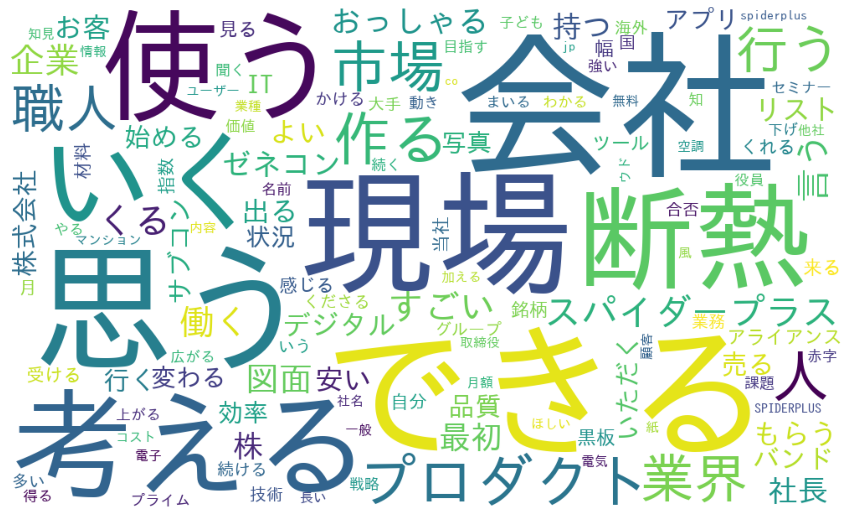

In [17]:
#wordcloud取込用に辞書型ヘ変換
dic_result = dict(result)

#Word Cloudで画像生成
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white',
                      max_words=125,
                      font_path='/usr/share/fonts/truetype/fonts-japanese-gothic.ttf',
                      width=1000,
                      height=600,
                      ).fit_words(dic_result)

#生成した画像の表示
import matplotlib.pyplot as plt 
from matplotlib import rcParams

plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [18]:
#donutsデータダウンロード
import requests

url = "https://github.com/hima2b4/Word-Cloud/raw/main/donuts.png"

file_name = "donuts.png"

response = requests.get(url)
image = response.content

with open(file_name, "wb") as f:
    f.write(image)

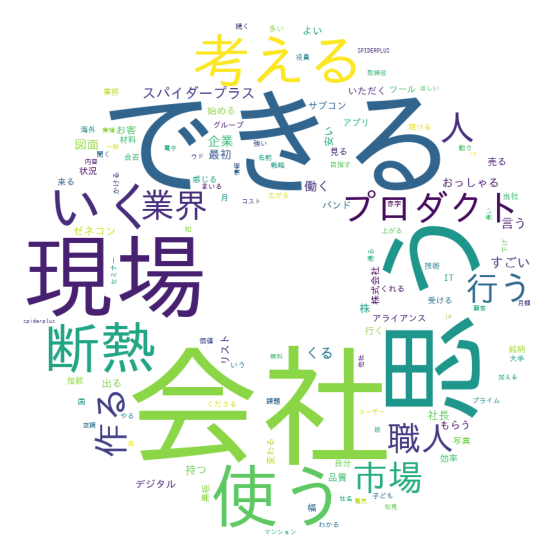

In [19]:
#ライブラリインポート
from PIL import Image
import numpy as np

custom_mask = np.array(Image.open('donuts.png'))
wordcloud = WordCloud(background_color='white',
                      max_words=125,
                      mask=custom_mask,
                      font_path='/usr/share/fonts/truetype/fonts-japanese-gothic.ttf',
                      width=1200,
                      height=1200
                      ).fit_words(dic_result)

#生成した画像の表示
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

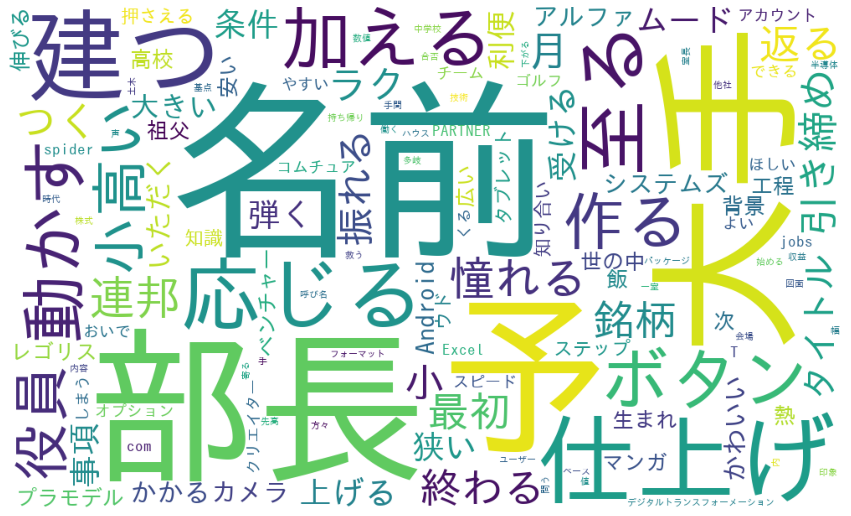

In [20]:
#Word Cloudで画像生成
wordcloud = WordCloud(background_color='white',
                      max_words=125,
                      font_path='/usr/share/fonts/truetype/fonts-japanese-gothic.ttf',
                      width=1000,
                      height=600,
                      ).generate_from_frequencies(tfidf_dict)

#生成した画像の表示
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()